# Imports

In [178]:
%pip install pandas numpy matplotlib seaborn scikit-learn xgboost
%pip freeze > requirements.txt
# pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [180]:
df = pd.read_csv('Dados/desafio_indicium_imdb.csv', index_col=0)
df_top_movies = pd.read_csv('Dados/top_year_movies.csv')
df.rename(columns={'Series_Title': 'title'}, inplace=True)
df = pd.merge(df, df_top_movies, on='title', how='outer')

In [181]:
df = df.drop(columns=['rating_imdb'])

target = 'IMDB_Rating'
df = df.dropna(subset=[target])

In [182]:
df['Runtime'] = df['Runtime'].str.replace(' min', '', regex=False).astype(int)
df['Runtime'].head()

21      95
71      96
79     134
117    119
147    149
Name: Runtime, dtype: int64

In [183]:
df['Released_Year'] = pd.to_numeric(df['Released_Year'].str.replace(',', '', regex=False), errors='coerce')
df['Released_Year'].head()

21     2009.0
71     1957.0
79     2013.0
117    2019.0
147    1968.0
Name: Released_Year, dtype: float64

In [184]:
df['Gross'] = pd.to_numeric(df['Gross'].str.replace(',', '', regex=False), errors='coerce')
df['Gross'].head()

21      32391374.0
71       4360000.0
79      56671993.0
117    159227644.0
147     56954992.0
Name: Gross, dtype: float64

# EDA

## Geral

In [185]:
df.head(2)

,title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,id,link,year,duration,rating_mpa,vote,budget,gross_world_wide,gross_us_canada,gross_opening_weekend,director,writer,star,genre,country_origin,filming_location,production_company,language,win,nomination,oscar
21,(500) Days of Summer,2009.0,UA,95,"Comedy, Drama, Romance",7.7,"An offbeat romantic comedy about a woman who doesn't believe true love exists, and the young man who falls for her.",76.0,Marc Webb,Zooey Deschanel,Joseph Gordon-Levitt,Geoffrey Arend,Chloë Grace Moretz,472242.0,32391374.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,12 Angry Men,1957.0,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarriage of justice by forcing his colleagues to reconsider the evidence.,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845.0,4360000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
df.columns

Index(['title', 'Released_Year', 'Certificate', 'Runtime', 'Genre',
       'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4', 'No_of_Votes', 'Gross', 'id', 'link', 'year',
       'duration', 'rating_mpa', 'vote', 'budget', 'gross_world_wide',
       'gross_us_canada', 'gross_opening_weekend', 'director', 'writer',
       'star', 'genre', 'country_origin', 'filming_location',
       'production_company', 'language', 'win', 'nomination', 'oscar'],
      dtype='object')

In [187]:
df.shape

(1104, 36)

In [188]:
df.describe()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,year,vote,budget,gross_world_wide,gross_us_canada,gross_opening_weekend,win,nomination,oscar
count,1103.000000,1104.000000,1104.000000,933.000000,1.104000e+03,9.250000e+02,783.000000,7.830000e+02,6.490000e+02,6.900000e+02,6.520000e+02,5.930000e+02,783.0,783.000000,783.000000
mean,1991.310970,123.132246,7.944203,77.993569,2.747243e+05,7.122691e+07,1996.899106,1.423339e+06,5.165698e+07,1.839053e+08,8.497509e+07,1.763819e+07,0.0,38.754789,0.664112
std,23.061237,29.417196,0.271864,12.337613,3.172512e+05,1.110250e+08,16.551285,4.014217e+06,1.310853e+08,3.214917e+08,1.195147e+08,3.622051e+07,0.0,54.019520,1.377877
min,1920.000000,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03,1960.000000,1.400000e+01,2.000000e+03,3.570000e+02,3.622000e+03,4.320000e+02,0.0,0.000000,0.000000
25%,1977.000000,102.000000,7.700000,70.000000,5.669625e+04,3.969893e+06,1985.000000,6.800000e+04,6.000000e+06,9.966327e+06,6.982804e+06,1.621790e+05,0.0,5.000000,0.000000
50%,1998.000000,119.000000,7.900000,79.000000,1.432500e+05,2.554487e+07,2000.000000,2.140000e+05,1.800000e+07,6.027637e+07,4.095555e+07,1.645502e+06,0.0,19.000000,0.000000
75%,2009.000000,137.000000,8.100000,87.000000,3.793138e+05,9.374000e+07,2010.500000,5.445000e+05,5.200000e+07,2.106674e+08,1.101160e+08,1.982869e+07,0.0,48.500000,1.000000
max,2020.000000,321.000000,9.200000,100.000000,2.303232e+06,9.366622e+08,2024.000000,2.600000e+07,2.500000e+09,2.923706e+09,9.366622e+08,3.571150e+08,0.0,382.000000,11.000000


In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1104 entries, 21 to 33914
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  1104 non-null   object 
 1   Released_Year          1103 non-null   float64
 2   Certificate            999 non-null    object 
 3   Runtime                1104 non-null   int64  
 4   Genre                  1104 non-null   object 
 5   IMDB_Rating            1104 non-null   float64
 6   Overview               1104 non-null   object 
 7   Meta_score             933 non-null    float64
 8   Director               1104 non-null   object 
 9   Star1                  1104 non-null   object 
 10  Star2                  1104 non-null   object 
 11  Star3                  1104 non-null   object 
 12  Star4                  1104 non-null   object 
 13  No_of_Votes            1104 non-null   float64
 14  Gross                  925 non-null    float64
 15  id     

## Hipoteses

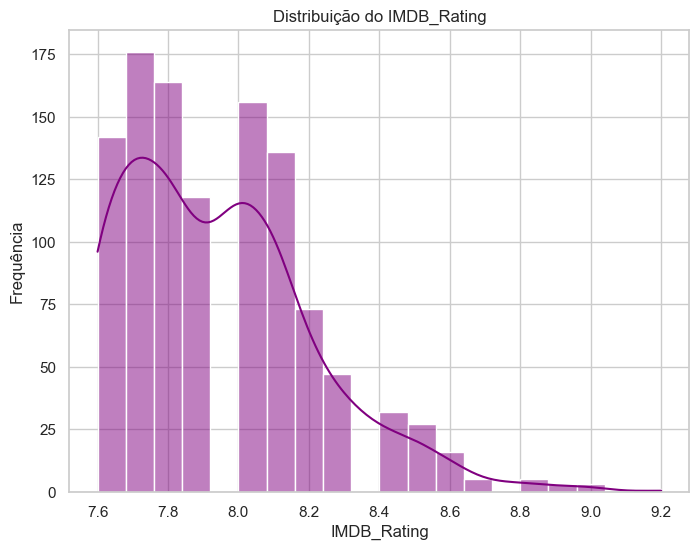

In [190]:
plt.figure(figsize=(8,6))
sns.histplot(df['IMDB_Rating'], bins=20, kde=True, color='purple')
plt.title('Distribuição do IMDB_Rating')
plt.xlabel('IMDB_Rating')
plt.ylabel('Frequência')
plt.show()

Filmes com mais votos (No_of_Votes) tendem a ter nota mais alta?

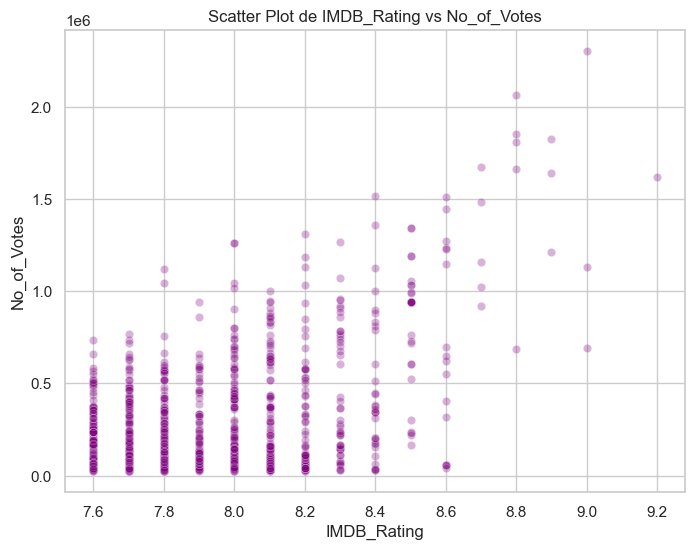

In [191]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='IMDB_Rating', y='No_of_Votes', alpha=0.3, color='purple')
plt.title('Scatter Plot de IMDB_Rating vs No_of_Votes')
plt.show()

Filmes com maior Meta_score tendem a ter nota maior no IMDB?

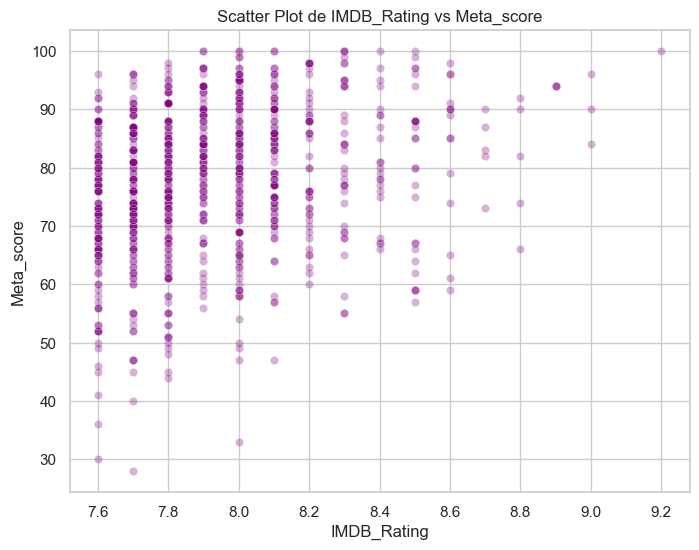

In [192]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='IMDB_Rating', y='Meta_score', alpha=0.3, color='purple')
plt.title('Scatter Plot de IMDB_Rating vs Meta_score')
plt.show()

Filmes mais longos (Runtime) podem ter notas maiores?

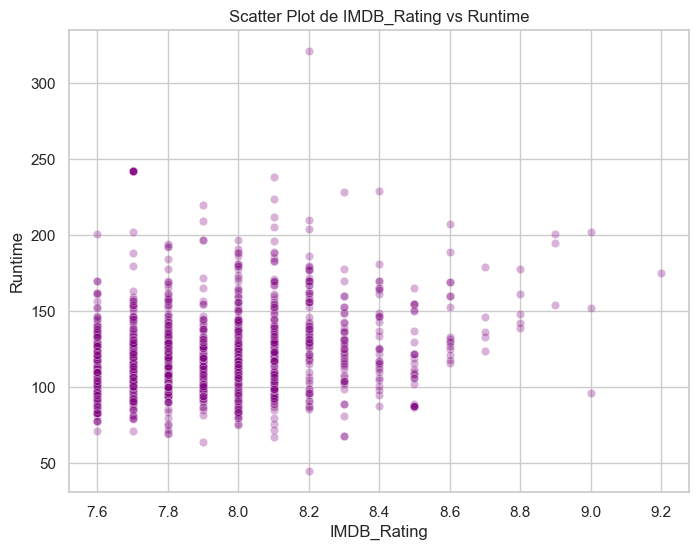

In [193]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='IMDB_Rating', y='Runtime', alpha=0.3, color='purple')
plt.title('Scatter Plot de IMDB_Rating vs Runtime')
plt.show()

Filmes com maior faturamento tendem a ter maior nota?

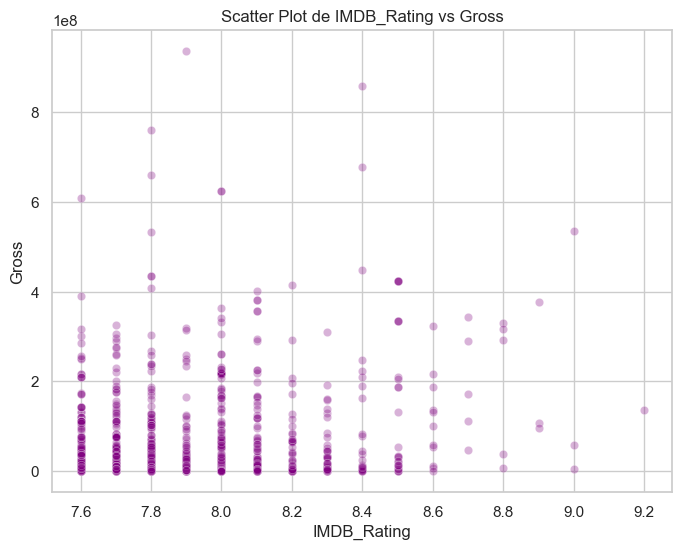

In [194]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='IMDB_Rating', y='Gross', alpha=0.3, color='purple')
plt.title('Scatter Plot de IMDB_Rating vs Gross')
plt.show()

Filmes mais recentes tendem a ter notas diferentes?

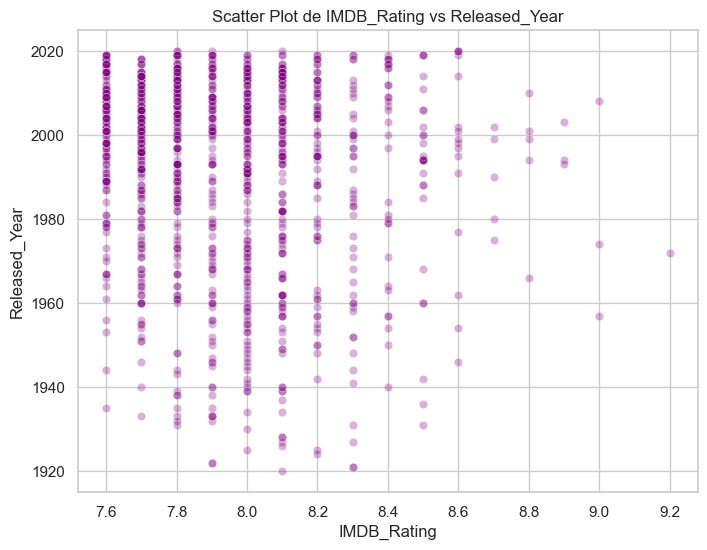

In [195]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='IMDB_Rating', y='Released_Year', alpha=0.3, color='purple')
plt.title('Scatter Plot de IMDB_Rating vs Released_Year')
plt.show()

2️⃣ Relação entre IMDB_Rating e variáveis categóricas

Hipótese: Alguns gêneros (Genre) tendem a receber notas mais altas.Visualização: Boxplot do IMDB_Rating por gênero (sns.boxplot(x='Genre', y='IMDB_Rating', data=df)).

Hipótese: Certificações etárias (Certificate) podem influenciar a nota (ex: filmes adultos vs familiares).Visualização: Boxplot ou violin plot.

Hipótese: Diretores ou atores populares (Director, Star1) podem impactar a nota.Visualização: Agrupar e calcular média de IMDB_Rating por diretor ou ator; gráfico de barras para os top 10.

3️⃣ Faturamento (Gross)

Hipótese: Filmes de certos gêneros têm maior faturamento.Visualização: Boxplot de Gross por gênero.

4️⃣ Texto do Overview

Hipótese: Palavras-chave no Overview podem indicar gênero ou impacto na nota.Visualização: Wordclouds por gênero ou correlação de frequência de palavras com IMDB_Rating.

# Modelo

In [ ]:
X = df.drop(columns=[target])
y = df[target]

X_encoded = X.copy()

# Transformar colunas object em números
for col in X_encoded.select_dtypes(include=['object']).columns:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col].astype(str))
X = X_encoded.copy()

# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Criar o modelo XGBoost Regressor
model = xgb.XGBRegressor(
    n_estimators=100,   # número de árvores
    learning_rate=0.1,  # taxa de aprendizado
    max_depth=5,        # profundidade máxima da árvore
    random_state=42
)

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

importances = model.feature_importances_

# Criar um DataFrame para organizar
feat_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feat_importances)

Mean Squared Error: 0.03
R² Score: 0.56
                  Feature  Importance
12            No_of_Votes    0.178172
6              Meta_score    0.086836
31               language    0.069140
19                   vote    0.068120
13                  Gross    0.045691
16                   year    0.034206
23  gross_opening_weekend    0.032893
1           Released_Year    0.030994
3                 Runtime    0.030307
14                     id    0.029966
17               duration    0.029050
27                  genre    0.028802
10                  Star3    0.021594
5                Overview    0.019297
34                  oscar    0.019138
21       gross_world_wide    0.018787
15                   link    0.018743
24               director    0.017569
22        gross_us_canada    0.017454
8                   Star1    0.017176
30     production_company    0.015996
28         country_origin    0.015487
25                 writer    0.015093
29       filming_location    0.014978
9         